**Objective**: Learn how to solve a Multiclass classification problem using neural network in PyTorch.

**Task**:In this class exercise, you will implement a MultiClass classification using the same house pricing dataset previously used for a regression task. To adapt the dataset for multiclass classification, we have categorized the dataset's numeric response (target) variable into three classes: low, medium, and high, represented by 0, 1, and 2, respectively. The data has also been scaled to facilitate this analysis. The modified dataset is ready for you in the CSV file CaliforniaHousing_classification.csv

For this class exsrcise you will again train two models.

>Model 1: Train model without accounting for imbalance <br>
>Model 2: Train model accounting for imbalance

**Plan**:
1. Set Environment: Load and understand the libraries needed.
2. Load Data: Load house price data for this lab and explore it.
3. Split Data: Learn how to split data into training, validation and testing
4. Create Datasets
5. Define functions we need to train and evaluate Models 1, and 2.
6. Model 1 : Train Model 1 (without accounting for Imbalance)
> 6.1. Define Hyperparameters <br>
> 6.2. Define Training Configurations <br>
> 6.3. Model Training and Evaluation <br>

7. Model 2: Train Model 2 (accounting for Imbalance)
> 7.1. Define Hyperparameters <br>
> 7.2. Define Training Configurations <br>
> 7.3. Model Training and Evaluation <br>


**For the class exercise**,
- enter your code into the cells that contain the placeholder **# CODE.**
- Answer question in marksdown cell with **Your response here**

**Note**: For the class exercise, we will focus only on training the model and we will neither do model evaluation nor inference.

# <Font color = 'indianred'>**1. Set Environment**

In [ ]:
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix

# Data handling and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random

# file manipulation
from google.colab import drive
from pathlib import Path

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


In [ ]:
if 'google.colab' in str(get_ipython()):
  drive.mount('/content/drive')
  base_folder = Path('/content/drive/MyDrive/data')
else:
  base_folder = Path('/home/harpreet/Insync/google_drive_shaannorr/data')

Mounted at /content/drive


In [ ]:
data_folder = base_folder/'datasets'
model_folder = base_folder/'models/nlp_spring_2024/multiclass'
model_folder.mkdir(exist_ok=True, parents = True)
data_folder.mkdir(exist_ok=True, parents = True)

# <Font color = 'indianred'>**2. Load Data**



In [ ]:
df = pd.read_csv(data_folder/'CaliforniaHousing_classification.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MedInc              20640 non-null  float64
 1   HouseAge            20640 non-null  float64
 2   AveRooms            20640 non-null  float64
 3   AveBedrms           20640 non-null  float64
 4   Population          20640 non-null  float64
 5   AveOccup            20640 non-null  float64
 6   Latitude            20640 non-null  float64
 7   Longitude           20640 non-null  float64
 8   HouseValueCategory  20640 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.4 MB


In [ ]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HouseValueCategory
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835,2
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844,2
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827,2
3,0.932968,1.856182,0.156966,-0.049833,-0.766028,-0.050329,1.038503,-1.337818,2
4,-0.012881,1.856182,0.344711,-0.032906,-0.759847,-0.085616,1.038503,-1.337818,2


In [ ]:
df['HouseValueCategory'].value_counts(normalize=True)*100

1    70.179264
2    16.191860
0    13.628876
Name: HouseValueCategory, dtype: float64

The value counts for the 'HouseValueCategory' in the dataset reveal a significant imbalance among the different categories of house prices: low (0), medium (1), and high (2). Specifically, medium-priced houses constitute a majority with approximately 70.18% of the data, followed by high-priced houses at about 16.19%, and low-priced houses at 13.63%.

In [ ]:
# Drop the target column, HouseValueCategory, from inputs, X; y is the target column
X = df.drop(['HouseValueCategory'], axis=1).values
y = df['HouseValueCategory'].values

In [ ]:
X.shape, y.shape

In [ ]:
type(X), type(y)

In [ ]:
X.shape, y.shape

((20640, 8), (20640,))

# <Font color = 'indianred'>**3. Split Data**

In [ ]:
# Splitting the data into training and temporary sets (60% - 40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# Splitting the temporary set into validation and test sets (50% - 50% of 40%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Print the shapes of the splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (12384, 8) (12384,)
Validation set shape: (4128, 8) (4128,)
Test set shape: (4128, 8) (4128,)


# <Font color = 'indianred'>**4. Create Dataset**


In [ ]:
class CustomDataset(torch.utils.data.Dataset):

  def __init__(self, X, y):

    # Storing feature data (texts)
    self.X = X
    # Storing the target labels
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):

    # Retrieve the text and corresponding label from the dataset using the index
    inputs = self.X[idx]
    labels = self.y[idx]

    inputs = torch.tensor(inputs, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)  # same as torch.int64

    # Packing them into a tuple before returning
    sample = (inputs, labels)

    return sample

In [ ]:
# Create TensorDatasets for each set
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_dataset, val_dataset, test_dataset

(<__main__.CustomDataset at 0x784c22e8a7a0>,
 <__main__.CustomDataset at 0x784c22e89ba0>)

# <Font color = 'indianred'>**5. Functions to train & evaluate Models**



## <Font color = 'indianred'>*`step()` function*

In [ ]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to calculate loss.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """
    # Move the model and data to the device
    model = model.to(device)
    inputs = inputs.to(device)

    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2b: Calculate the number of correctly classified samples
    predicted = torch.argmax(outputs.data, 1)
    correct = (predicted == targets).sum().item()

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if loss_function:
      return loss, outputs, correct
    else:
      return None, outputs, correct

## <Font color = 'indianred'>*`train_epoch()` function*

In [ ]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to calculate loss.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_acc (float): Training accuracy for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0
    running_train_correct = 0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Perform a forward and backward pass, updating model parameters
        loss, _, correct = step(inputs, targets, model, device, loss_function, optimizer)

        # Update running loss and correct predictions counter
        running_train_loss += loss.item()
        running_train_correct += correct

    # Compute average loss and accuracy for the entire training set
    train_loss = running_train_loss / len(train_loader)
    train_acc = running_train_correct / len(train_loader.dataset)

    return train_loss, train_acc


## <Font color = 'indianred'>*`val_epoch()` function*

In [ ]:
def val_epoch(valid_loader, model, device, loss_function):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to calculate loss.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_acc (float): Validation accuracy for the epoch.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and correct predictions
    running_val_loss = 0.0
    running_val_correct = 0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Perform a forward pass to get loss and number of correct predictions
            loss, _, correct = step(inputs, targets, model, device, loss_function, optimizer=None)

            # Update running loss and correct predictions counter
            running_val_loss += loss.item()
            running_val_correct += correct

    # Compute average loss and accuracy for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    val_acc = running_val_correct / len(valid_loader.dataset)

    return val_loss, val_acc


## <Font color = 'indianred'>*`train()` function*

In [ ]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to to calculate loss.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_acc_history (list): History of training accuracy for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_acc_history (list): History of validation accuracy for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_acc = train_epoch(train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_acc = val_epoch(valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)

        # Output epoch-level summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}%")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_acc*100:.2f}%")
        print()

    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history


# <Font color = 'indianred'>**6. Train Model 1 (without accounting for imbalance)**

## <Font color = 'indianred'>*6.1 Hyperparameters*

In [ ]:
# Hyperparameters
batch_size = 64
learning_rate = 0.1
number_inputs = 8
number_outputs = # CODE HERE
number_hidden_1 = 100
number_hidden_2 = 100
epochs = 10

## <Font color = 'indianred'>*6.2 Training Configurations*

In [ ]:
# Fixing the seed value for reproducibility across runs
SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Cross Entropy  Loss function
loss_function = # CODE HERE

# model
hidden_1 = # CODE HERE
hidden_2 = # CODE HERE
output_layer = # CODE HERE
model_1 = # CODE HERE


# Define the optimizer - use SGD
optimizer = # CODE HERE

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## <Font color = 'indianred'>*6.3 Moddel Training*

In [ ]:
# Call the train function to train the model
train_losses, train_acc, valid_losses, valid_acc  = train(
    train_loader, val_loader, model_1, optimizer, loss_function, epochs, device)

**Plot losses**

In [ ]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")  # Plot training losses
    if val_losses:  # Check if validation losses are provided
        plt.plot(epochs, val_losses, label="Validation")  # Plot validation losses
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation metrics
    if train_metrics[0] is not None:  # Check if training metrics are available
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")  # Plot training metrics
        if val_metrics:  # Check if validation metrics are provided
            plt.plot(epochs, val_metrics, label="Validation")  # Plot validation metrics
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()


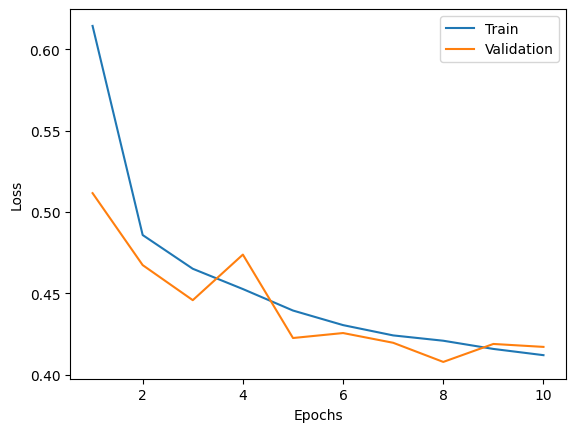

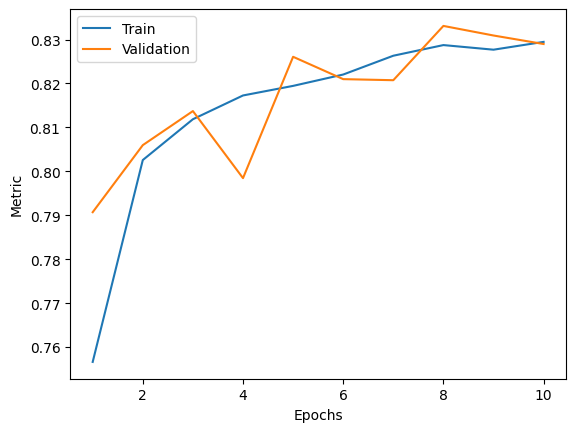

In [ ]:
plot_history(train_losses, train_acc, valid_losses, valid_acc)

**Model checkpointing**



In [ ]:
# file name for model to save
file_name_1 = model_folder/'two_layer.pt'

In [ ]:
torch.save(model_1.state_dict(), file_name_1)

**Evaluate model on validation dataset**


In [ ]:
def get_acc_pred(data_loader, model, device):
    """
    Function to get predictions and accuracy for a given data using a trained model
    Input: data iterator, model, device
    Output: predictions and accuracy for the given dataset
    """
    model = model.to(device)
    # Set model to evaluation mode
    model.eval()

    # Create empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)
    running_correct = 0
    # Iterate over batches from data iterator
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Process the batch to get the loss, outputs, and correct predictions
            _, outputs, correct = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None)

            # Choose the label with maximum probability
            _, predicted = torch.max(outputs.data, 1)

            # Add the predicted labels and actual labels to their respective tensors
            predictions = torch.cat((predictions, predicted))
            y = torch.cat((y, targets.to(device)))
            running_correct += correct

    # Calculate accuracy by comparing the predicted and actual labels
    accuracy = running_correct / len(data_loader.dataset)

    # Return tuple containing predictions and accuracy
    return predictions, y, accuracy

In [ ]:
predictions_valid, labels_valid, acc_valid = get_acc_pred(val_loader, model_1, device)

In [ ]:
acc_valid

0.8289728682170543

In [ ]:
def plot_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots a confusion matrix.

    Args:
        valid_labels (array-like): True labels of the validation data.
        valid_preds (array-like): Predicted labels of the validation data.
        class_labels (list): List of class names for the labels.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(valid_labels, valid_preds, normalize='true')

    # Plot the confusion matrix using Seaborn
    # 'ax' represents the axes of the plot. Seaborn's heatmap is used for visualizing the confusion matrix
    # 'annot=True' displays the values in the cells, and 'fmt' specifies the string formatting for these values
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)

    # Rotating the tick labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Adding labels and title to the plot
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()


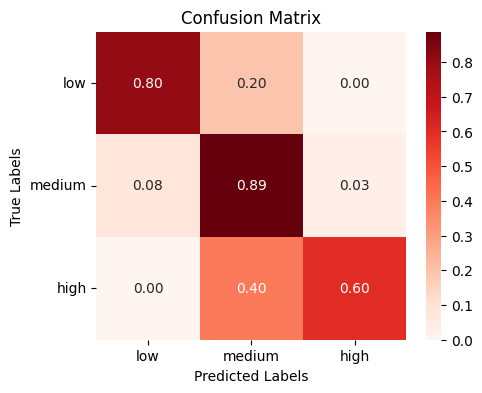

In [ ]:
plot_confusion_matrix( labels_valid.cpu().numpy(), predictions_valid.cpu().numpy(), ['low', 'medium', 'high'])

**What do you conclude from the confusion matrix?**

(Hint: refer to the section2 , where we calculatee the count_values for the response)

**Your Response here:**



# <Font color = 'indianred'>**7. Train Model 2 (accounting for imbalance)**



In [ ]:
# Get unique values and their counts
unique, counts = np.unique(y_train, return_counts=True)

# Create a dictionary for value counts
value_counts = dict(zip(unique, counts))

print(value_counts)

{0: 1688, 1: 8691, 2: 2005}


In [ ]:
# Class counts: Low, Medium, High
class_counts = list(value_counts.values())

# Total number of samples
total = sum(class_counts)

# Calculate weights for each class
weights = torch.tensor([total / c for c in class_counts], dtype=torch.float32)
weights = weights.to('cuda')
weights

tensor([7.3365, 1.4249, 6.1766], device='cuda:0')

## <Font color = 'indianred'>*7.1 Hyperparameters*

In [ ]:
# Hyperparameters
batch_size = 64
learning_rate = 0.1
number_inputs = 8
number_outputs =  # CODE HERE
number_hidden_1 = 100
number_hidden_2 = 100
epochs = 10

## <Font color = 'indianred'>*7.2 Training Configurations*

In [ ]:
# Fixing the seed value for reproducibility across runs
SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Cross Entropy  Loss function
loss_function = # CODE HERE

# model
hidden_1 = # CODE HERE
hidden_2 = # CODE HERE
output_layer = # CODE HERE
model_1 = # CODE HERE


# Define the optimizer - use SGD
optimizer = # CODE HERE

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## <Font color = 'indianred'>*7.3 Model Training*

In [ ]:
# Call the train function to train the model
train_losses, train_acc, valid_losses, valid_acc  = train(
    train_loader, val_loader, model_2, optimizer, loss_function, epochs, device)

**Plot losses**

In [ ]:
plot_history(train_losses, train_acc, valid_losses, valid_acc)

**Model checkpointing**

In [ ]:
# file name for model to save
file_name_2 = model_folder/'two_layer_cost.pt'

In [ ]:
torch.save(model_2.state_dict(), file_name_2 )

**Evaluate Model on validation set**

In [ ]:
predictions_valid, labels_valid, acc_valid = get_acc_pred(val_loader, model_2, device)

In [ ]:
acc_valid

0.7025193798449613

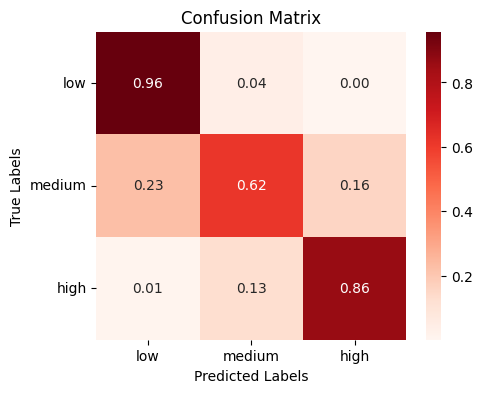

In [ ]:
plot_confusion_matrix( labels_valid.cpu().numpy(), predictions_valid.cpu().numpy(), ['low', 'medium', 'high'])

**What conclusion you draw from the confusion matrix?**

**Your response here**


